Importar archivo y hacer un daaFrame de Pnadas


In [10]:
from google.colab import drive
import pandas as pd

In [12]:
# Montar Drive
drive.mount('/content/drive')

# Ruta al archivo (ajusta con la ruta de tu Drive)
ruta = "/content/drive/MyDrive/TelecomX_Data.json"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Cargar JSON
df = pd.read_json("/content/drive/MyDrive/TelecomX_Data.json")

In [17]:
#valores ausente
# Cantidad de valores ausentes por columna
print(df.isnull().sum())

# Porcentaje de valores ausentes
print((df.isnull().sum() / len(df)) * 100)

customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64
customerID    0.0
Churn         0.0
customer      0.0
phone         0.0
internet      0.0
account       0.0
dtype: float64


In [23]:
# Aplanar 'customer' y 'account'
df_customer = pd.json_normalize(df['customer'])
df_account = pd.json_normalize(df['account'])

# Combinar con el resto del DataFrame
df_flat = pd.concat([df.drop(['customer','account'], axis=1), df_customer, df_account], axis=1)

In [25]:
# Detectar columnas que contienen diccionarios o listas
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
        df[col] = df[col].apply(str)

# Ahora buscar duplicados
duplicados = df[df.duplicated()]
print(f"Número de filas duplicadas: {len(duplicados)}")
print(duplicados)

Número de filas duplicadas: 0
Empty DataFrame
Columns: [customerID, Churn, customer, phone, internet, account]
Index: []


In [27]:
# Ver tipos de datos
print(df.dtypes)

# Ver ejemplo de cada columna
print(df.head())


customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'Onl

In [28]:

# Aplanar 'customer', 'phone', 'internet', 'account'
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Combinar con el resto del DataFrame
df_flat = pd.concat([df.drop(['customer','phone','internet','account'], axis=1),
                     df_customer, df_phone, df_internet, df_account], axis=1)

In [29]:
# Tipos de datos
print(df_flat.dtypes)

# Categorías únicas
categorical_cols = ['Churn','PhoneService','MultipleLines','InternetService',
                    'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                    'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

for col in categorical_cols:
    if col in df_flat.columns:
        print(f"{col}: {df_flat[col].unique()}")

customerID    object
Churn         object
dtype: object
Churn: ['No' 'Yes' '']


In [31]:
# Opción 1: Convertir vacío a NaN
df_flat['Churn'] = df_flat['Churn'].replace('', pd.NA)

In [32]:
print(df_flat['Churn'].unique())

['No' 'Yes' <NA>]


# Manejo de inconsistencias


In [34]:
# Función para limpiar strings: eliminar espacios y estandarizar mayúsculas/minúsculas
def clean_category(x):
    if isinstance(x, str):
        return x.strip().title()
    return x

# Aplicar a todas las columnas categóricas
for col in df_flat.select_dtypes(include='object').columns:
    df_flat[col] = df_flat[col].apply(clean_category)

In [35]:
# Revisión rápida de valores ausentes
print(df_flat.isna().sum())

# Revisión rápida de categorías
for col in df_flat.select_dtypes(include='object').columns:
    print(f"{col}: {df_flat[col].unique()}")

customerID      0
Churn         224
dtype: int64
customerID: ['0002-Orfbo' '0003-Mknfe' '0004-Tlhlj' ... '9992-Ujoel' '9993-Lhieb'
 '9995-Hotoh']
Churn: ['No' 'Yes' <NA>]


In [36]:
df_clean = df_flat.dropna(subset=['Churn'])

In [37]:
df_flat['Churn'] = df_flat['Churn'].fillna('Unknown')

# Columna de cuentas diarias

In [44]:
# Extraer MonthlyCharges desde el diccionario anidado
def obtener_mensual(x):
    # x ya debería ser dict; si es string, convertir primero
    if isinstance(x, str):
        import ast
        x = ast.literal_eval(x)
    return float(x.get('Charges', {}).get('Monthly', 0))

df['MonthlyCharges'] = df['account'].apply(obtener_mensual)

# Crear columna Cuentas_Diarias
df['Cuentas_Diarias'] = (df['MonthlyCharges'] / 30).round(2)

# Verificar resultados
print(df[['customerID', 'MonthlyCharges', 'Cuentas_Diarias']].head())

   customerID  MonthlyCharges  Cuentas_Diarias
0  0002-ORFBO            65.6             2.19
1  0003-MKNFE            59.9             2.00
2  0004-TLHLJ            73.9             2.46
3  0011-IGKFF            98.0             3.27
4  0013-EXCHZ            83.9             2.80


# Estandarización y transformación de datos (opcional)


In [45]:
df.rename(columns={
    'customerID': 'ClienteID',
    'Churn': 'Canceló',
    'MonthlyCharges': 'FacturaMensual',
    'Cuentas_Diarias': 'CuentaDiaria'
}, inplace=True)

In [46]:
# Convertir 'No' → 0 y 'Yes' → 1
df['Canceló'] = df['Canceló'].map({'No': 0, 'Yes': 1})

In [47]:
df['CuentaDiaria'] = df['CuentaDiaria'].round(2)

In [48]:
print(df.head())
print(df.info())

    ClienteID  Canceló                                           customer  \
0  0002-ORFBO      0.0  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE      0.0  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ      1.0  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF      1.0  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ      1.0  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'Onlin

# Análisis Descriptivo

In [50]:
# Análisis descriptivo para columnas numéricas
numericas = df.select_dtypes(include=['float64', 'int64'])
desc_num = numericas.describe().T  # Transpuesta para mejor lectura
desc_num['mediana'] = numericas.median()
desc_num['rango'] = desc_num['max'] - desc_num['min']

print("Análisis descriptivo de variables numéricas:")
print(desc_num)

# Para columnas categóricas
categoricas = df.select_dtypes(include=['object'])
print("\nDistribución de categorías:")
for col in categoricas.columns:
    print(f"\nColumna: {col}")
    print(df[col].value_counts(dropna=False))

Análisis descriptivo de variables numéricas:
                 count       mean        std    min     25%    50%     75%  \
Canceló         7043.0   0.265370   0.441561   0.00   0.000   0.00   1.000   
FacturaMensual  7267.0  64.720098  30.129572  18.25  35.425  70.30  89.875   
CuentaDiaria    7267.0   2.157292   1.004407   0.61   1.180   2.34   2.995   

                   max  mediana   rango  
Canceló           1.00     0.00    1.00  
FacturaMensual  118.75    70.30  100.50  
CuentaDiaria      3.96     2.34    3.35  

Distribución de categorías:

Columna: ClienteID
ClienteID
9995-HOTOH    1
0002-ORFBO    1
0003-MKNFE    1
9970-QBCDA    1
9968-FFVVH    1
             ..
0014-BMAQU    1
0013-SMEOE    1
0013-MHZWF    1
0013-EXCHZ    1
0011-IGKFF    1
Name: count, Length: 7267, dtype: int64

Columna: customer
customer
{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 1}         223
{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents'

# Distribución de evasión

/tmp/ipython-input-1750873865.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='pastel')


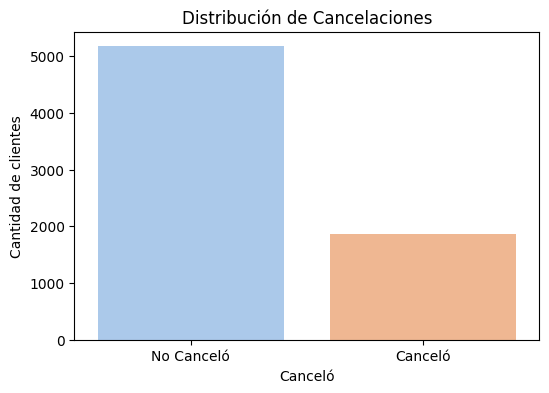

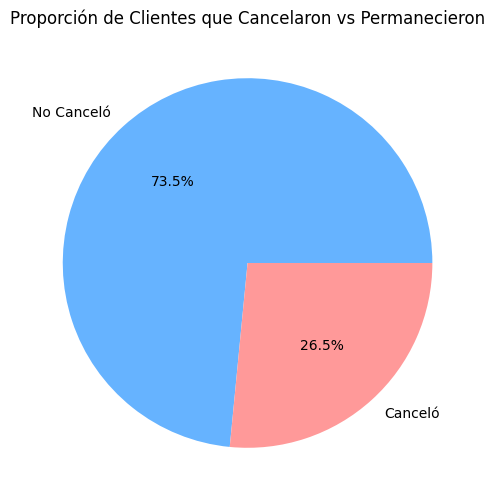

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar la cantidad de clientes que cancelaron y los que no
churn_counts = df['Canceló'].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='pastel')
plt.xticks([0,1], ['No Canceló', 'Canceló'])
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de Cancelaciones')
plt.show()

# Gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(churn_counts.values, labels=['No Canceló', 'Canceló'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Proporción de Clientes que Cancelaron vs Permanecieron')
plt.show()

# Recuento de evasión por variables categóricas

In [54]:
import json

# Función para convertir string a diccionario JSON
def parse_account(x):
    try:
        # Reemplazamos comillas simples por dobles
        x = x.replace("'", '"')
        # Convertimos a diccionario
        return json.loads(x)
    except:
        return None

df['account'] = df['account'].apply(parse_account)

# Ahora sí podemos extraer las columnas
df['Contract'] = df['account'].apply(lambda x: x['Contract'] if x else None)
df['PaperlessBilling'] = df['account'].apply(lambda x: x['PaperlessBilling'] if x else None)
df['PaymentMethod'] = df['account'].apply(lambda x: x['PaymentMethod'] if x else None)
df['MonthlyCharges'] = df['account'].apply(lambda x: x['Charges']['Monthly'] if x else None)
df['TotalCharges'] = df['account'].apply(lambda x: x['Charges']['Total'] if x else None)

In [60]:
# Extraer columnas de 'customer' (asumiendo que siempre hay diccionarios aquí)
df['gender'] = df['customer'].apply(lambda x: x['gender'])
df['SeniorCitizen'] = df['customer'].apply(lambda x: x['SeniorCitizen'])
df['Partner'] = df['customer'].apply(lambda x: x['Partner'])
df['Dependents'] = df['customer'].apply(lambda x: x['Dependents'])
df['tenure'] = df['customer'].apply(lambda x: x['tenure'])

# Extraer columnas de 'account', manejando None
df['Contract'] = df['account'].apply(lambda x: x['Contract'] if x is not None else None)
df['PaperlessBilling'] = df['account'].apply(lambda x: x['PaperlessBilling'] if x is not None else None)
df['PaymentMethod'] = df['account'].apply(lambda x: x['PaymentMethod'] if x is not None else None)
df['MonthlyCharges'] = df['account'].apply(lambda x: x['Charges']['Monthly'] if x is not None else None)
df['TotalCharges'] = df['account'].apply(lambda x: float(x['Charges']['Total']) if x is not None else None)

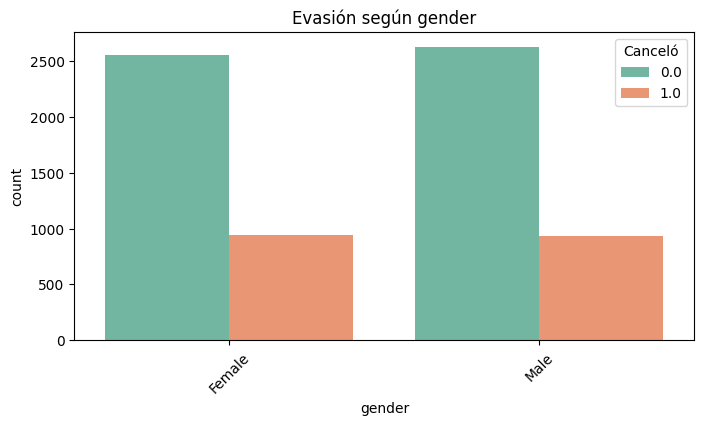

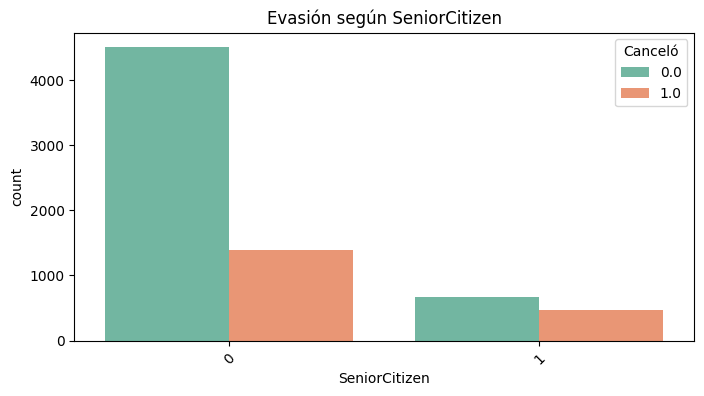

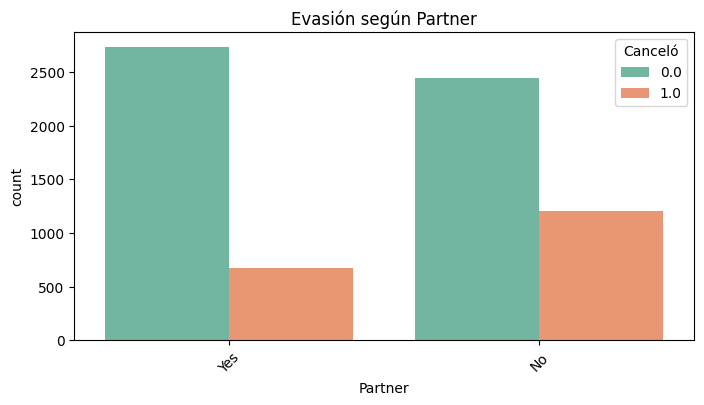

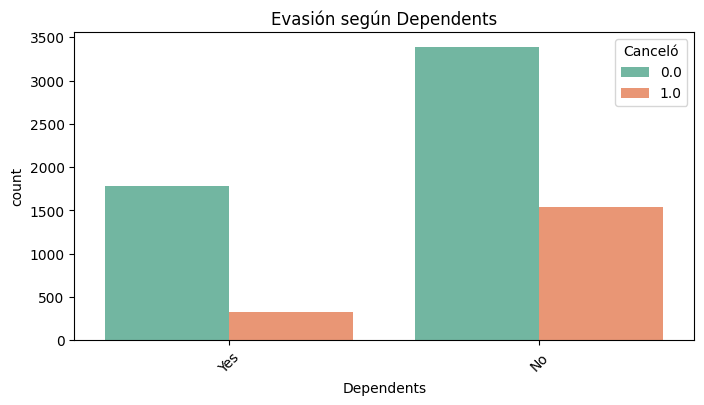

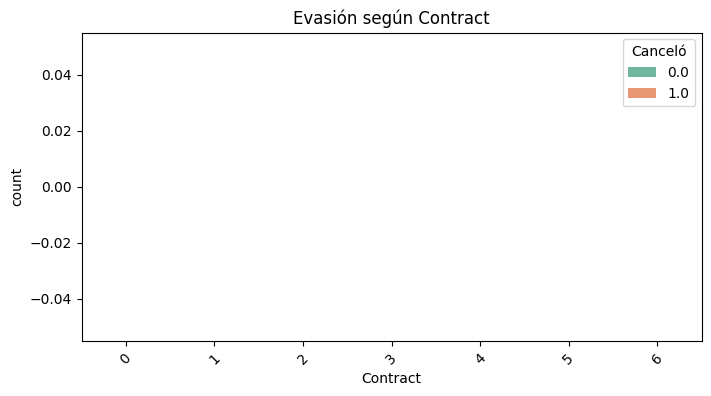

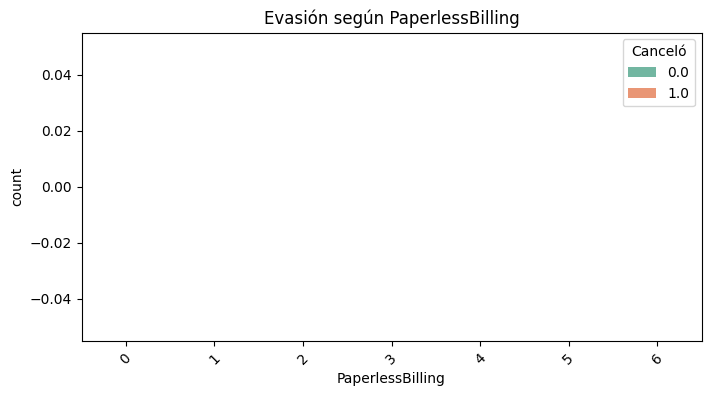

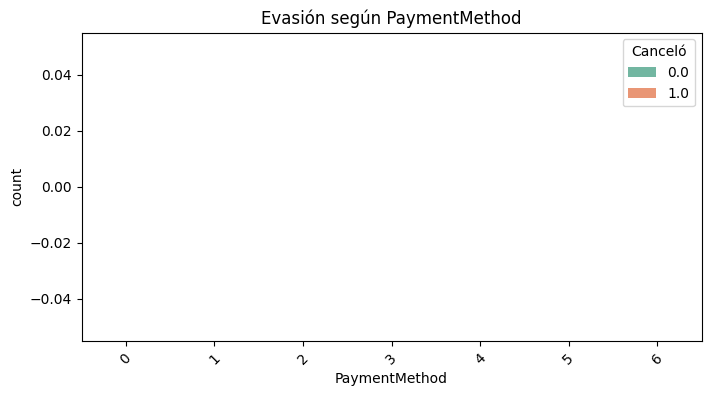

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='Canceló', palette='Set2')
    plt.title(f'Evasión según {col}')
    plt.xticks(rotation=45)
    plt.show()

# Conteo de evasión por variables numéricas

In [63]:
print(df.columns)
print(df['Canceló'].unique())

Index(['ClienteID', 'Canceló', 'customer', 'phone', 'internet', 'account',
       'FacturaMensual', 'CuentaDiaria', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'tenure'],
      dtype='object')
[ 0.  1. nan]


In [64]:
df['Canceló'] = df['Canceló'].astype('category')


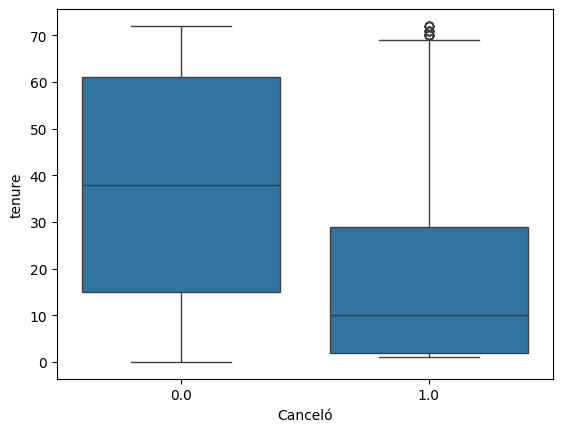

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Canceló', y='tenure', data=df)
plt.show()

# ¡Extra! Análisis de correlación entre variables

In [71]:
# Convertir columnas relevantes a números
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Convertir la columna de churn a 0 y 1
df['Canceló_num'] = df['Canceló'].map({'No': 0, 'Sí': 1})

In [75]:
correlation_matrix = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Canceló_num']].corr()
print(correlation_matrix)

                tenure  MonthlyCharges  TotalCharges  Canceló_num
tenure             1.0             NaN           NaN          NaN
MonthlyCharges     NaN             NaN           NaN          NaN
TotalCharges       NaN             NaN           NaN          NaN
Canceló_num        NaN             NaN           NaN          NaN


In [76]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].info()
df[['tenure', 'MonthlyCharges', 'TotalCharges']].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7267 non-null   int64  
 1   MonthlyCharges  0 non-null      float64
 2   TotalCharges    0 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 170.4 KB


,tenure,MonthlyCharges,TotalCharges
0,9,NaN,NaN
1,9,NaN,NaN
2,4,NaN,NaN
3,13,NaN,NaN
4,3,NaN,NaN
5,9,NaN,NaN
6,71,NaN,NaN
7,63,NaN,NaN
8,7,NaN,NaN
9,65,NaN,NaN


In [78]:
# Quitar espacios y convertir a float, poniendo NaN en errores
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')

df[['tenure', 'MonthlyCharges', 'TotalCharges']].isnull().sum()

,0
tenure,0
MonthlyCharges,7267
TotalCharges,7267


In [79]:
df = df.dropna(subset=['tenure', 'MonthlyCharges', 'TotalCharges'])
# o, si quieres rellenar con 0:
# df[['tenure', 'MonthlyCharges', 'TotalCharges']] = df[['tenure', 'MonthlyCharges', 'TotalCharges']].fillna(0)

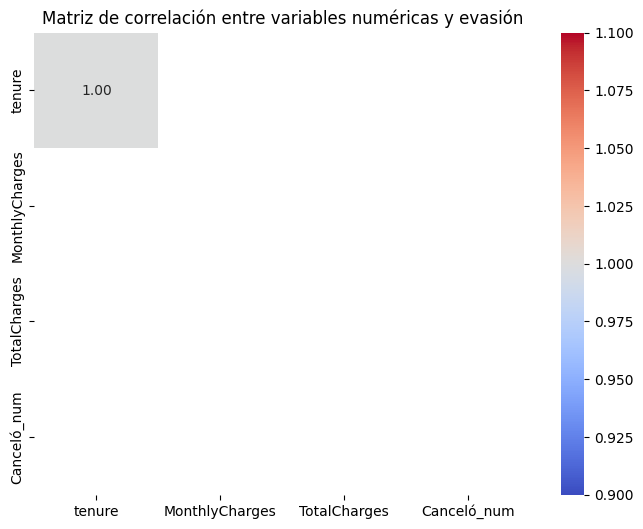

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas y evasión")
plt.show()

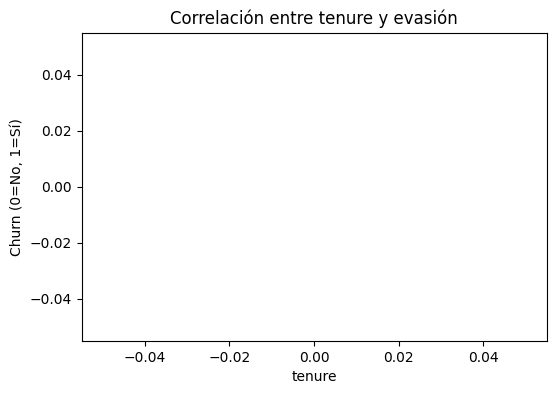

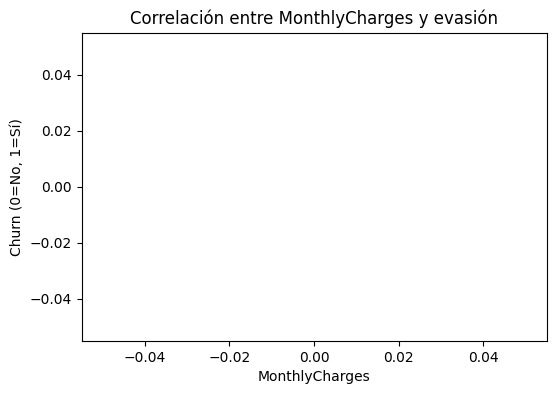

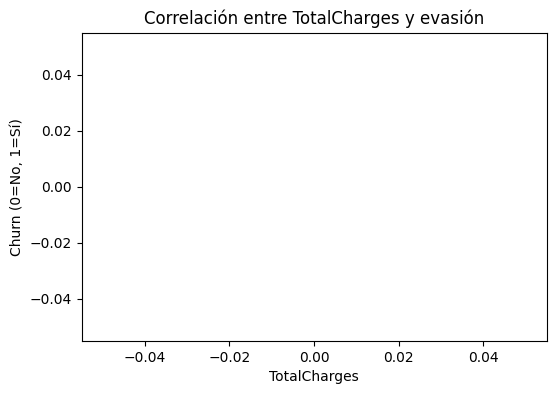

In [81]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y='Canceló_num')
    plt.title(f'Correlación entre {col} y evasión')
    plt.xlabel(col)
    plt.ylabel('Churn (0=No, 1=Sí)')
    plt.show()